In [11]:
import pandas as pd
import numpy as np
import json
import ast

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import pickle

import nltk, re
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')

from utils import read_config
from pandas.io.json import json_normalize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\N0tE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
config = read_config("config.json")
# config['dataset_path'] = Path(config['dataset_path'])

In [3]:
def load_csv(path, origin):
    df = pd.read_csv(config['dataset_path'] + path, sep=';', parse_dates=['publish_time'])
    df.columns = list(map(str.strip, df.columns))
    df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m')
    df['origin'] = origin
    return df

us_videos_df = load_csv('US_videos_5p.csv', 'US')
# gb_videos_df = load_csv('GB_videos_5p.csv', 'GB')

# videos_df = pd.concat([us_videos_df, gb_videos_df]).reset_index(drop=True)
# videos_df['origin'] = videos_df['origin'].astype('category')
videos_df = us_videos_df

# Pierwsze 3 i ostatnie 3 wartości
videos_df.iloc[[0,1,2,-3,-2,-1]]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US
40946,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,NaN,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,US
40947,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,NaN,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,US
40948,ooyjaVdt-jA,2018-06-14,Official Call of Duty®: Black Ops 4 — Multipla...,Call of Duty,NaN,2018-05-17 17:09:38+00:00,"call of duty|""cod""|""activision""|""Black Ops 4""",10306119,357079,212976,144795,https://i.ytimg.com/vi/ooyjaVdt-jA/default.jpg,False,False,False,Call of Duty: Black Ops 4 Multiplayer raises t...,US


In [6]:
# Create date features
df = videos_df[['publish_time', 'trending_date']]

def handle_dates(df, cols):
    for col in cols:
        df[col+'_day'] = df.publish_time.dt.day
        df[col+'_month'] = df.publish_time.dt.month
        df[col+'_year'] = df.publish_time.dt.year
        df[col+'_weekday'] = df.publish_time.dt.dayofweek
        df[col+'_quarter'] = df.publish_time.dt.quarter
        # TODO - add hours handling if there are any
    return df

df = handle_dates(df, ['publish_time'])
df

ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be

,publish_time,trending_date,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter
0,2017-11-13 17:13:01+00:00,2017-11-14,13,11,2017,0,4
1,2017-11-13 07:30:00+00:00,2017-11-14,13,11,2017,0,4
2,2017-11-12 19:05:24+00:00,2017-11-14,12,11,2017,6,4
3,2017-11-13 11:00:04+00:00,2017-11-14,13,11,2017,0,4
4,2017-11-12 18:01:41+00:00,2017-11-14,12,11,2017,6,4
...,...,...,...,...,...,...,...
40944,2018-05-18 13:00:04+00:00,2018-06-14,18,5,2018,4,2
40945,2018-05-18 01:00:06+00:00,2018-06-14,18,5,2018,4,2
40946,2018-05-18 17:34:22+00:00,2018-06-14,18,5,2018,4,2
40947,2018-05-17 17:00:04+00:00,2018-06-14,17,5,2018,3,2


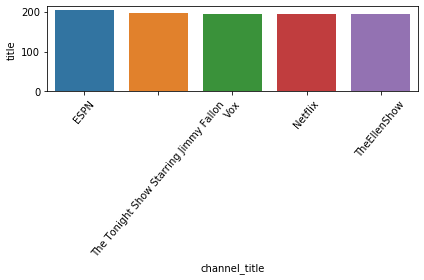

In [7]:
# Top 5 trending channels
df = videos_df
df_trending_ch = df.groupby(by=['channel_title'], as_index=False).count().sort_values(by='title', ascending=False).head()
sns.barplot(
    x = 'channel_title',
    y = 'title',
    data = df_trending_ch)
plt.xticks(rotation=50)
plt.tight_layout()

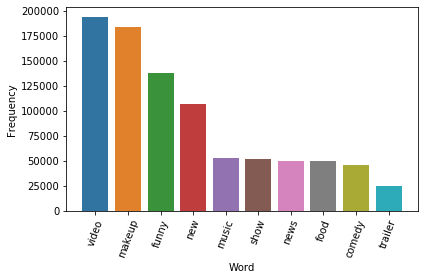

In [8]:
stopwords = list(stopwords.words('english'))   
# stopwords[:5]

df = videos_df

for col in ['description', 'tags']:

    wordtokens = word_tokenize(re.sub('[^A-Za-z]+', ' ', df[col].str.lower().str.cat(sep=' ')))
    # wordtokens[:4]

    # Remove stopwords, numbers and short words
    w_temp = []
    for word in wordtokens:
        if (word not in stopwords) and (len(word) > 2) and not (word.isnumeric()):
            w_temp.append(word)

    # w_temp[:4]

    word_dist = nltk.FreqDist(w_temp)
    df_temp = pd.DataFrame(word_dist.most_common(100), columns=['Word', 'Frequency'])
    sns.barplot(x="Word", y="Frequency", data=df_temp.head(10))
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.plot()

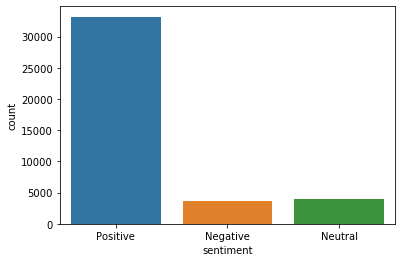

In [13]:
# Sentiment analysis
from textblob import TextBlob

def change_sentiment_display(df):
    if df['sentiment'] > 0: return 'Positive'
    elif df['sentiment'] < 0: return 'Negative'
    elif df['sentiment'] == 0: return 'Neutral'

df_temp = videos_df['description'].astype(str)
blobi = []
for sentence in df_temp:
    blob = TextBlob(sentence)
    blobi.append((
        sentence,
        blob.sentiment.polarity,
        blob.sentiment.subjectivity))

df_temp_blob = pd.DataFrame(
    blobi,
    columns = ['sentence', 'sentiment', 'polarity'])

df_temp_blob['sentiment'] = df_temp_blob.apply(change_sentiment_display, axis=1)
sns.countplot(x="sentiment", data=df_temp_blob)

In [12]:
# Word2Vec with vector averaging

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

stopwords = list(stopwords.words('english'))   

df_temp = videos_df['description'].astype(str)
sentences = []
for sentence in df_temp:
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
    sentence_temp = []
    for word in sentence:
        if (word not in stopwords) and (len(word) > 2) and not (word.isnumeric()):
            sentence_temp.append(word)
    sentences.append(sentence_temp)

print(sentences[:10])

[['shantell', 'channel', 'candice', 'filmed', 'video', 'lens', 'big', 'drone', 'gear', 'sony', 'camera', 'old', 'camera', 'main', 'lens', 'big', 'sony', 'camera', 'big', 'canon', 'camera', 'bendy', 'tripod', 'thing', 'need', 'bendy', 'tripod', 'wide', 'lens', 'expensive', 'wide', 'lens', 'small', 'camera', 'microphone', 'microphone', 'old', 'drone', 'cheaper', 'still', 'great', 'follow', 'amazing', 'intro', 'song', 'disclosure', 'selling', 'promoting', 'anything', 'samsung', 'produce', 'shantell', 'video', 'galaxy', 'project', 'initiative', 'enables', 'creators', 'like', 'shantell', 'make', 'projects', 'might', 'otherwise', 'opportunity', 'make', 'hope', 'clear', 'ask', 'comments', 'answer', 'specifics'], ['one', 'year', 'presidential', 'election', 'john', 'oliver', 'discusses', 'learned', 'far', 'enlists', 'catheter', 'cowboy', 'teach', 'donald', 'trump', 'connect', 'last', 'week', 'tonight', 'online', 'subscribe', 'last', 'week', 'tonight', 'youtube', 'channel', 'almost', 'news', 'al

In [14]:
import gensim

model = gensim.models.Word2Vec(sentences, iter=100, min_count=5, size=200)

In [28]:
def clear_sentence(sentence):
    try:
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
        sentence_temp = []
        for word in sentence:
            if (word not in stopwords) and (len(word) > 2) and not (word.isnumeric()):
                sentence_temp.append(word)
        return sentence_temp
    except TypeError:
        return []

df = videos_df

descriptions = df.apply(lambda w: clear_sentence(w['description']), axis=1).values

In [39]:
def word_averaging(wv, sequence):
    mean = []
    for word in sequence:
        if word in wv.vocab: mean.append(wv.get_vector(word))
    if not mean: return np.zeros(200,)
    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, sequences):
    return np.vstack([word_averaging(wv, w) for w in sequences])

descriptions = word_averaging_list(model.wv, descriptions)

array([[-7.42989704e-02, -8.58205408e-02, -1.32045776e-01,
        -3.81379426e-02,  9.98580307e-02, -1.19165098e-03,
        -2.39765104e-02,  4.58782129e-02,  1.48661155e-02,
         9.30228606e-02,  4.95167263e-02,  6.59634359e-03,
        -1.66211985e-02,  1.21514231e-01,  6.90885857e-02,
         1.61293317e-02,  3.92779615e-03, -7.08517013e-03,
         1.08060949e-02, -9.33746323e-02,  1.70653742e-02,
        -7.72007629e-02, -1.76394898e-02,  1.19622566e-01,
        -1.16334833e-01, -1.28223643e-01, -5.01594367e-03,
         2.18580081e-03, -5.81055321e-02, -5.26702590e-02,
        -4.23588492e-02,  7.56233707e-02, -1.65363550e-02,
        -6.68374822e-02,  8.28262493e-02,  1.39721287e-02,
         1.29469305e-01, -5.59990853e-03, -5.32135852e-02,
         5.50604314e-02,  7.52280205e-02, -3.13794501e-02,
         6.28068224e-02,  5.79588488e-02,  5.18061279e-04,
        -2.12594867e-02, -6.76180841e-03, -1.71943717e-02,
        -1.35028899e-01, -5.91891073e-02, -4.49869148e-0

In [43]:
df['description_embedding'] = list(descriptions)
df.head(5)

(40949, 200)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,description_embedding
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,"[-0.07429897040128708, -0.08582054078578949, -..."
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,"[0.04557962715625763, 0.02588125504553318, -0...."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US,"[0.09881920367479324, -0.13671353459358215, -0..."
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,NaN,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US,"[0.017135674133896828, 0.07319894433021545, -0..."
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,NaN,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US,"[0.05340683460235596, 0.041816119104623795, -0..."


In [46]:
def _hash(object, trim):
    obj = hash(object)
    return np.float32(str(obj)[:trim])

for col, trim in zip(['channel_title'], [12]):
    df[col] = df[col].apply(_hash, trim=trim).astype(np.float32)

#df['channel_title'].nunique() 2207 - unique --> 12 binary
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,description_embedding
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,7.552329e+11,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,"[-0.07429897040128708, -0.08582054078578949, -..."
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,6.347334e+11,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,"[0.04557962715625763, 0.02588125504553318, -0...."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",-2.951604e+10,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US,"[0.09881920367479324, -0.13671353459358215, -0..."
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,-7.598336e+10,NaN,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US,"[0.017135674133896828, 0.07319894433021545, -0..."
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,2.751008e+11,NaN,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US,"[0.05340683460235596, 0.041816119104623795, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,2018-06-14,The Cat Who Caught the Laser,3.936667e+11,NaN,2018-05-18 13:00:04+00:00,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,US,"[0.02926602214574814, 0.014111015945672989, -0..."
40945,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,6.450682e+11,NaN,2018-05-18 01:00:06+00:00,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN,US,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40946,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,-5.131841e+10,NaN,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,US,"[0.0012940436135977507, -0.01808091066777706, ..."
40947,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,8.459760e+11,NaN,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,US,"[0.14884626865386963, -0.017476674169301987, 0..."
